In [ ]:
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.2 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import json
import numpy as np
import tenseal as ts

# Upload the JSON file (This is still done on the server)
uploaded = files.upload()
filename = list(uploaded.keys())[0]

with open(filename, "r") as f:
    data = json.load(f)

Saving MMU (1).json to MMU (1).json


In [ ]:
# DIAGNOSTIC: Check if your dataset features are normalized
sample_user = list(data.keys())[0]
sample_feature = data[sample_user]["features"][0]
sample_norm = np.linalg.norm(sample_feature)

print(f"\n=== DATASET DIAGNOSTIC ===")
print(f"Sample user: {sample_user}")
print(f"Sample feature norm: {sample_norm:.4f}")
print(f"Sample feature first 5 values: {sample_feature[:5]}")

if 0.9 < sample_norm < 1.1:
    print("✓ Dataset features appear to be NORMALIZED (norm ≈ 1.0)")
    print("  Your enrollment is correct - storing normalized vectors")
    print("  You need to normalize raw features during authentication")
elif sample_norm > 100:
    print("⚠️ Dataset features appear to be RAW (norm > 100)")
    print("  Your enrollment is INCORRECT - you should normalize before encryption!")
    print("  You need to modify your enrollment code to normalize features")
else:
    print(f"ℹ️ Dataset feature norm = {sample_norm:.4f} - unknown scale")


=== DATASET DIAGNOSTIC ===
Sample user: 1
Sample feature norm: 422.7161
Sample feature first 5 values: [61.632883687062844, -396.98667856760574, -57.09253633425689, -102.23017577972524, 59.844164158961874]
⚠️ Dataset features appear to be RAW (norm > 100)
  Your enrollment is INCORRECT - you should normalize before encryption!
  You need to modify your enrollment code to normalize features


In [ ]:
# First, let's inspect what users we actually have in the original data
print("Users in original data:", list(data.keys())[:10])  # Show first 10 user IDs
print("Total users in data:", len(data))

# Check if user '1' exists in the original data
if '1' not in data:
    print("WARNING: User '1' does not exist in the original data!")
    # Let's use the first available user instead
    first_user_id = list(data.keys())[0]
    print(f"Using first available user: {first_user_id}")
else:
    first_user_id = '1'

Users in original data: ['1', '2', '3', '5', '6', '7', '8', '9', '10', '11']
Total users in data: 43


In [ ]:
# Secure storage for private keys
user_private_keys = {}

# Database to store encrypted data
encrypted_database = {}

print("\n=== BUILDING ENCRYPTED DATABASE WITH NORMALIZATION ===")


def normalize_vector(v):
    import numpy as np
    v = np.array(v, dtype=np.float64)
    norm = np.linalg.norm(v)
    return (v / norm).tolist() if norm > 0 else v.tolist()

for user_id, user_data in data.items():
    print(f"Processing User {user_id}...")

    try:
        # Generate encryption context
        user_context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
        )
        user_context.generate_galois_keys()
        user_context.global_scale = 2 ** 40

        # Store private key
        user_private_key = user_context.serialize(save_secret_key=True)
        user_private_keys[user_id] = user_private_key
        print(f"  ✓ Private key stored for user {user_id}")

        # Create public context
        user_public_context = user_context.copy()
        user_public_context.make_context_public()

        # ============================================
        # FIX: NORMALIZE EACH VECTOR BEFORE ENCRYPTION
        # ============================================
        user_encrypted_features = []
        for vec in user_data["features"]:
            # THIS IS THE KEY LINE - NORMALIZE FIRST!
            normalized_vec = normalize_vector(vec)

            # Encrypt the normalized vector
            enc_vec = ts.ckks_vector(user_public_context, normalized_vec)
            user_encrypted_features.append(enc_vec.serialize())

        # Store in database
        user_public_key = user_public_context.serialize()
        encrypted_database[user_id] = {
            'public_key': user_public_key,
            'encrypted_features': user_encrypted_features
        }

        print(f"  ✓ Added User {user_id} to database with {len(user_encrypted_features)} NORMALIZED features")

    except Exception as e:
        print(f"  ✗ Error with User {user_id}: {e}")
        continue

print(f"✓ Enrollment completed. Stored private keys for {len(user_private_keys)} users")


=== BUILDING ENCRYPTED DATABASE WITH NORMALIZATION ===
Processing User 1...
  ✓ Private key stored for user 1
  ✓ Added User 1 to database with 10 NORMALIZED features
Processing User 2...
  ✓ Private key stored for user 2
  ✓ Added User 2 to database with 10 NORMALIZED features
Processing User 3...
  ✓ Private key stored for user 3
  ✓ Added User 3 to database with 10 NORMALIZED features
Processing User 5...
  ✓ Private key stored for user 5
  ✓ Added User 5 to database with 10 NORMALIZED features
Processing User 6...
  ✓ Private key stored for user 6
  ✓ Added User 6 to database with 10 NORMALIZED features
Processing User 7...
  ✓ Private key stored for user 7
  ✓ Added User 7 to database with 10 NORMALIZED features
Processing User 8...
  ✓ Private key stored for user 8
  ✓ Added User 8 to database with 10 NORMALIZED features
Processing User 9...
  ✓ Private key stored for user 9
  ✓ Added User 9 to database with 10 NORMALIZED features
Processing User 10...
  ✓ Private key stored for

In [ ]:
# Verify the database was built correctly
print("\n=== DATABASE VERIFICATION ===")
print("Users in encrypted database:", sorted(list(encrypted_database.keys()))[:10])
print(f"Total users in encrypted database: {len(encrypted_database)}")

# Check if specific users exist
for user_id in ['1', '2', '3', '44']:
    if user_id in encrypted_database:
        print(f"✓ User {user_id} found in database")
    else:
        print(f"✗ User {user_id} NOT found in database")


=== DATABASE VERIFICATION ===
Users in encrypted database: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18']
Total users in encrypted database: 43
✓ User 1 found in database
✓ User 2 found in database
✓ User 3 found in database
✓ User 44 found in database


In [ ]:
def cosine_similarity_encrypted_public(v1, v2):
    """
    Compute cosine similarity using only homomorphic operations.
    Returns encrypted similarity score.
    """
    # Encrypted dot product
    dot_product = v1.dot(v2)

    # Encrypted squared norms
    norm_sq_v1 = v1.dot(v1)
    norm_sq_v2 = v2.dot(v2)

    # We can't decrypt the norms on server, so we return the encrypted components
    # Client will decrypt and compute final similarity
    return dot_product, norm_sq_v1, norm_sq_v2

In [ ]:
query_user_id = '30'
print(f"\n=== AUTHENTICATING USER {query_user_id} ===")

if query_user_id not in encrypted_database:
    print(f"ERROR: User {query_user_id} not found!")
    exit()


def normalize_vector(v):
    """Normalize vector to unit length for cosine similarity"""
    import numpy as np
    v = np.array(v, dtype=np.float64)
    norm = np.linalg.norm(v)
    if norm > 0:
        return v / norm
    return v


query_features = [
    [-184.4385283676479, -380.0918702719819, 58.24394355694988, -14.17605608344307, -5.490539341999458],  # Feature at index 5
    [-152.31733667075224, -232.14842111207594, 126.51469500573947, 30.395121455151507, -0.8805459418830637]   # Feature at index 6
]

print(f"✓ Selected {len(query_features)} query features: Feature 5 and Feature 6")

# CRITICAL: Normalize the features before encryption!
normalized_queries = []
for i, feat in enumerate(query_features):
    normalized = normalize_vector(feat)
    normalized_queries.append(normalized)

    # Print norms for debugging
    original_norm = np.linalg.norm(feat)
    normalized_norm = np.linalg.norm(normalized)
    print(f"  Feature {i+1}: original norm = {original_norm:.2f}, normalized norm = {normalized_norm:.2f}")

print("✓ All query features normalized to unit length")

# ============================================
# STEP 1: Retrieve the target user's public context
# ============================================
target_data = encrypted_database[query_user_id]
target_public_context = ts.context_from(target_data['public_key'])

# ============================================
# STEP 2: Encrypt NORMALIZED query vectors
# ============================================
enc_queries = []
for i, query_vec in enumerate(normalized_queries):
    # Convert numpy array to list for encryption
    enc_query = ts.ckks_vector(target_public_context, query_vec.tolist())
    enc_queries.append(enc_query)
print(f"✓ {len(enc_queries)} normalized query features encrypted with correct public key")

# ============================================
# STEP 3: Retrieve private context
# ============================================
try:
    if query_user_id not in user_private_keys:
        print(f"✗ No private key found for user {query_user_id}")
        print("  Make sure enrollment was run with proper key storage")
        exit()

    user_private_context = ts.context_from(user_private_keys[query_user_id])
    print("✓ Retrieved private context with secret key")

except Exception as e:
    print(f"✗ Failed to retrieve private context: {e}")
    exit()


=== AUTHENTICATING USER 30 ===
✓ Selected 2 query features: Feature 5 and Feature 6
  Feature 1: original norm = 426.74, normalized norm = 1.00
  Feature 2: original norm = 306.63, normalized norm = 1.00
✓ All query features normalized to unit length
✓ 2 normalized query features encrypted with correct public key
✓ Retrieved private context with secret key


In [ ]:
print(f"\n=== SERVER-SIDE COMPARISON (Processing {len(enc_queries)} features) ===")

target_data = encrypted_database[query_user_id]
target_public_context = ts.context_from(target_data['public_key'])
target_enc_features = target_data['encrypted_features']

# Store all encrypted results for each feature and each template
encrypted_results_all = []  # This will be a 2D list: [template_index][feature_index]

for template_idx, enc_feat_serialized in enumerate(target_enc_features):
    try:
        # Deserialize encrypted template vector with public context
        enc_feat = ts.ckks_vector_from(target_public_context, enc_feat_serialized)

        template_results = []

        # Compare each query feature with this template
        for feature_idx, enc_query in enumerate(enc_queries):
            # Compute encrypted similarity (dot product, norm squared) for each feature
            dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

            # Store encrypted results for this feature
            template_results.append({
                'dot_product': dot_product.serialize(),
                'norm_sq_v1': norm_sq_v1.serialize(),
                'norm_sq_v2': norm_sq_v2.serialize()
            })

        # Add all feature results for this template
        encrypted_results_all.append(template_results)
        print(f"  ✓ Template {template_idx + 1}: All {len(enc_queries)} feature comparisons completed")

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error during comparison: {e}")
        encrypted_results_all.append([])  # Empty list for failed template

print(f"\n=== CLIENT-SIDE DECRYPTION AND AVERAGE COMPUTATION ===")

decrypted_average_scores = []
successful_decryptions = 0

for template_idx, template_results in enumerate(encrypted_results_all):
    if not template_results:  # Skip failed comparisons
        print(f"  ✗ Template {template_idx + 1}: Skipping - no comparison results")
        decrypted_average_scores.append(0.0)
        continue

    try:
        feature_similarities = []

        # Decrypt and compute similarity for each feature
        for feature_idx, result in enumerate(template_results):
            # Deserialize encrypted vectors with private context (secret key)
            dot_product_enc = ts.ckks_vector_from(user_private_context, result['dot_product'])
            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v1'])
            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, result['norm_sq_v2'])

            # Decrypt the components
            dot_product = dot_product_enc.decrypt()[0]
            norm_sq_v1_val = norm_sq_v1_enc.decrypt()[0]
            norm_sq_v2_val = norm_sq_v2_enc.decrypt()[0]

            # Calculate cosine similarity safely
            norm_sq_v1_val = max(0, norm_sq_v1_val)
            norm_sq_v2_val = max(0, norm_sq_v2_val)
            norm_v1 = np.sqrt(norm_sq_v1_val) if norm_sq_v1_val > 0 else 0
            norm_v2 = np.sqrt(norm_sq_v2_val) if norm_sq_v2_val > 0 else 0

            if norm_v1 == 0 or norm_v2 == 0:
                similarity = 0.0
            else:
                similarity = dot_product / (norm_v1 * norm_v2)

            similarity = max(-1.0, min(1.0, similarity))
            feature_similarities.append(similarity)

        # Calculate average similarity across all features for this template
        average_similarity = sum(feature_similarities) / len(feature_similarities)
        decrypted_average_scores.append(average_similarity)
        successful_decryptions += 1

        # Display individual feature results and average
        print(f"  ✓ Template {template_idx + 1}:")
        for i, sim in enumerate(feature_similarities):
            print(f"      Feature {i + 1} similarity: {sim:.4f}")
        print(f"      Average similarity: {average_similarity:.4f}")

    except Exception as e:
        print(f"  ✗ Template {template_idx + 1}: Error decrypting: {e}")
        decrypted_average_scores.append(0.0)


=== SERVER-SIDE COMPARISON (Processing 2 features) ===
  ✓ Template 1: All 2 feature comparisons completed
  ✓ Template 2: All 2 feature comparisons completed
  ✓ Template 3: All 2 feature comparisons completed
  ✓ Template 4: All 2 feature comparisons completed
  ✓ Template 5: All 2 feature comparisons completed
  ✓ Template 6: All 2 feature comparisons completed
  ✓ Template 7: All 2 feature comparisons completed
  ✓ Template 8: All 2 feature comparisons completed
  ✓ Template 9: All 2 feature comparisons completed
  ✓ Template 10: All 2 feature comparisons completed

=== CLIENT-SIDE DECRYPTION AND AVERAGE COMPUTATION ===
  ✓ Template 1:
      Feature 1 similarity: 0.7369
      Feature 2 similarity: 0.8056
      Average similarity: 0.7713
  ✓ Template 2:
      Feature 1 similarity: 0.8420
      Feature 2 similarity: 0.8328
      Average similarity: 0.8374
  ✓ Template 3:
      Feature 1 similarity: 0.5157
      Feature 2 similarity: 0.3139
      Average similarity: 0.4148
  ✓ Templa

In [ ]:
print(f"\n=== FINAL AUTHENTICATION RESULTS (Average of {len(query_features)} Features) ===")
print(f"Successful decryptions: {successful_decryptions}/{len(target_enc_features)}")

if successful_decryptions > 0:
    # Create list with (user_id, average_similarity) tuples
    client_side_scores = [(query_user_id, score) for score in decrypted_average_scores]
    client_side_scores = sorted(client_side_scores, key=lambda x: x[1], reverse=True)

    print(f"\nTop Matches (Average of {len(query_features)} Features):")
    for i, (uid, avg_sim) in enumerate(client_side_scores[:5]):
        print(f"  {i+1}. User {uid} [Template {i+1}] -> Average Similarity: {avg_sim:.4f}")

    threshold = 0.75
    best_match = client_side_scores[0]

    print(f"\nAuthentication Threshold: {threshold}")
    print(f"Best Match Average Similarity: {best_match[1]:.4f}")

    if best_match[1] >= threshold:
        print(f"✓ Authenticated as User {best_match[0]} with average similarity {best_match[1]:.4f} ✅")
    else:
        print(f"✗ Authentication failed. Best match is User {best_match[0]} with average similarity {best_match[1]:.4f} ❌")

    # Additional diagnostic information
    print(f"\n=== DIAGNOSTIC INFORMATION ===")
    print(f"Number of query features used: {len(query_features)}")
    print(f"Number of templates processed: {len(target_enc_features)}")

    # Show individual feature performances
    if decrypted_average_scores:
        print(f"\nIndividual Template Results:")
        for i, avg_score in enumerate(decrypted_average_scores):
            if avg_score > 0:  # Only show successful ones
                print(f"  Template {i+1}: Average Score = {avg_score:.4f}")

else:
    print("✗ No successful decryptions - authentication failed")


=== FINAL AUTHENTICATION RESULTS (Average of 2 Features) ===
Successful decryptions: 10/10

Top Matches (Average of 2 Features):
  1. User 30 [Template 1] -> Average Similarity: 0.9707
  2. User 30 [Template 2] -> Average Similarity: 0.9407
  3. User 30 [Template 3] -> Average Similarity: 0.8954
  4. User 30 [Template 4] -> Average Similarity: 0.8844
  5. User 30 [Template 5] -> Average Similarity: 0.8578

Authentication Threshold: 0.75
Best Match Average Similarity: 0.9707
✓ Authenticated as User 30 with average similarity 0.9707 ✅

=== DIAGNOSTIC INFORMATION ===
Number of query features used: 2
Number of templates processed: 10

Individual Template Results:
  Template 1: Average Score = 0.7713
  Template 2: Average Score = 0.8374
  Template 3: Average Score = 0.4148
  Template 4: Average Score = 0.8844
  Template 5: Average Score = 0.9407
  Template 6: Average Score = 0.7563
  Template 7: Average Score = 0.8578
  Template 8: Average Score = 0.8954
  Template 9: Average Score = 0.781

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
import seaborn as sns

def evaluate_authentication_performance(num_users=100, threshold_range=None, num_features_list=None):
    """
    Comprehensive performance evaluation of the authentication system

    Parameters:
    - num_users: Number of users to evaluate
    - threshold_range: Range of thresholds to test (default: 0.5 to 1.0)
    - num_features_list: List of different numbers of features to test
    """

    if threshold_range is None:
        threshold_range = np.arange(0.5, 1.0, 0.05)

    if num_features_list is None:
        num_features_list = [1, 2, 3, 4, 5]

    print("=" * 70)
    print("AUTHENTICATION SYSTEM PERFORMANCE EVALUATION")
    print("=" * 70)

    # Store all results
    all_results = {
        'genuine_scores': [],
        'impostor_scores': [],
        'metrics': {},
        'timing': {}
    }

    # Test different numbers of features
    for num_features in num_features_list:
        print(f"\n{'='*60}")
        print(f"EVALUATING WITH {num_features} FEATURE(S)")
        print(f"{'='*60}")

        genuine_scores = []
        impostor_scores = []
        processing_times = []

        # Track genuine and impostor attempts
        for query_user_id in list(data.keys())[:num_users]:
            if query_user_id not in encrypted_database:
                continue

            # Get query vectors (take first num_features available)
            query_features = []
            for i in range(min(num_features, len(data[query_user_id]["features"]))):
                query_features.append(data[query_user_id]["features"][i])

            if not query_features:
                continue

            # ========== GENUINE ATTEMPTS (Same User) ==========
            start_time = time.time()

            try:
                # Get target user's public context
                target_data = encrypted_database[query_user_id]
                target_public_context = ts.context_from(target_data['public_key'])

                # Encrypt query vectors
                enc_queries = []
                for query_vec in query_features:
                    enc_query = ts.ckks_vector(target_public_context, query_vec)
                    enc_queries.append(enc_query)

                # Get private context
                if query_user_id not in user_private_keys:
                    continue

                user_private_context = ts.context_from(user_private_keys[query_user_id])

                # Get encrypted features
                target_enc_features = target_data['encrypted_features']

                # Compare with each template
                best_score = 0
                for template_idx, enc_feat_serialized in enumerate(target_enc_features[:3]):  # Test with first 3 templates
                    try:
                        enc_feat = ts.ckks_vector_from(target_public_context, enc_feat_serialized)

                        feature_scores = []
                        for enc_query in enc_queries:
                            # Compute similarity
                            dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                            # Decrypt and compute similarity
                            dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                            norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                            norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                            dp = dot_product_enc.decrypt()[0]
                            n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                            n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                            norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                            norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                            if norm_v1 == 0 or norm_v2 == 0:
                                similarity = 0.0
                            else:
                                similarity = dp / (norm_v1 * norm_v2)

                            similarity = max(-1.0, min(1.0, similarity))
                            feature_scores.append(similarity)

                        # Average score for this template
                        avg_score = sum(feature_scores) / len(feature_scores)
                        best_score = max(best_score, avg_score)

                    except Exception as e:
                        continue

                genuine_scores.append(best_score)

                # ========== IMPOSTOR ATTEMPTS (Different Users) ==========
                # Test against 5 different users
                impostor_targets = [uid for uid in list(encrypted_database.keys())[:20]
                                  if uid != query_user_id][:5]

                for imposter_id in impostor_targets:
                    try:
                        imposter_data = encrypted_database[imposter_id]
                        imposter_public_context = ts.context_from(imposter_data['public_key'])

                        # Re-encrypt queries with imposter's public key
                        enc_queries_imposter = []
                        for query_vec in query_features:
                            enc_query = ts.ckks_vector(imposter_public_context, query_vec)
                            enc_queries_imposter.append(enc_query)

                        imposter_enc_features = imposter_data['encrypted_features']

                        imposter_score = 0
                        for enc_feat_serialized in imposter_enc_features[:2]:  # Test 2 templates
                            try:
                                enc_feat = ts.ckks_vector_from(imposter_public_context, enc_feat_serialized)

                                feature_scores = []
                                for enc_query in enc_queries_imposter:
                                    dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                                    # Use query user's private context to decrypt
                                    dot_product_enc = ts.ckks_vector_from(user_private_context, dot_product.serialize())
                                    norm_sq_v1_enc = ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize())
                                    norm_sq_v2_enc = ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize())

                                    dp = dot_product_enc.decrypt()[0]
                                    n1 = max(0, norm_sq_v1_enc.decrypt()[0])
                                    n2 = max(0, norm_sq_v2_enc.decrypt()[0])

                                    norm_v1 = np.sqrt(n1) if n1 > 0 else 0
                                    norm_v2 = np.sqrt(n2) if n2 > 0 else 0

                                    if norm_v1 == 0 or norm_v2 == 0:
                                        similarity = 0.0
                                    else:
                                        similarity = dp / (norm_v1 * norm_v2)

                                    similarity = max(-1.0, min(1.0, similarity))
                                    feature_scores.append(similarity)

                                avg_score = sum(feature_scores) / len(feature_scores)
                                imposter_score = max(imposter_score, avg_score)

                            except Exception as e:
                                continue

                        impostor_scores.append(imposter_score)

                    except Exception as e:
                        continue

                processing_time = time.time() - start_time
                processing_times.append(processing_time)

            except Exception as e:
                print(f"Error processing user {query_user_id}: {e}")
                continue

        # Calculate metrics
        if genuine_scores and impostor_scores:
            # Store scores
            all_results[f'genuine_{num_features}feat'] = genuine_scores
            all_results[f'impostor_{num_features}feat'] = impostor_scores
            all_results['timing'][f'avg_time_{num_features}feat'] = np.mean(processing_times)

            # Calculate metrics for different thresholds
            metrics = calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range)
            all_results['metrics'][num_features] = metrics

            # Print summary
            print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times)

    # Generate comprehensive visualizations
    generate_visualizations(all_results, threshold_range, num_features_list)

    return all_results

def calculate_performance_metrics(genuine_scores, impostor_scores, threshold_range):
    """Calculate various performance metrics"""
    metrics = {
        'thresholds': threshold_range,
        'far': [],  # False Acceptance Rate
        'frr': [],  # False Rejection Rate
        'gar': [],  # Genuine Acceptance Rate
        'eer': None,  # Equal Error Rate
        'auc': None,  # Area Under ROC Curve
        'best_threshold': None
    }

    # Calculate FAR and FRR for each threshold
    for threshold in threshold_range:
        # False Acceptance: Impostor accepted
        far = sum(score >= threshold for score in impostor_scores) / len(impostor_scores) if impostor_scores else 0

        # False Rejection: Genuine rejected
        frr = sum(score < threshold for score in genuine_scores) / len(genuine_scores) if genuine_scores else 0

        metrics['far'].append(far)
        metrics['frr'].append(frr)
        metrics['gar'].append(1 - frr)  # Genuine Acceptance Rate

    # Find Equal Error Rate (EER)
    min_diff_idx = np.argmin(np.abs(np.array(metrics['far']) - np.array(metrics['frr'])))
    metrics['eer'] = (metrics['far'][min_diff_idx] + metrics['frr'][min_diff_idx]) / 2
    metrics['best_threshold'] = threshold_range[min_diff_idx]

    # Calculate AUC for ROC curve
    y_true = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    y_scores = list(genuine_scores) + list(impostor_scores)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    metrics['auc'] = auc(fpr, tpr)

    # Calculate precision-recall metrics at best threshold
    tn = sum(score < metrics['best_threshold'] for score in impostor_scores)
    fp = sum(score >= metrics['best_threshold'] for score in impostor_scores)
    fn = sum(score < metrics['best_threshold'] for score in genuine_scores)
    tp = sum(score >= metrics['best_threshold'] for score in genuine_scores)

    metrics['confusion_matrix'] = [[tn, fp], [fn, tp]]
    metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    metrics['precision'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['recall'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall']) if (metrics['precision'] + metrics['recall']) > 0 else 0

    return metrics

def print_summary(num_features, genuine_scores, impostor_scores, metrics, processing_times):
    """Print summary of performance for given number of features"""
    print(f"\nSUMMARY FOR {num_features} FEATURE(S):")
    print("-" * 40)

    print(f"Number of genuine attempts: {len(genuine_scores)}")
    print(f"Number of impostor attempts: {len(impostor_scores)}")
    print(f"Average processing time: {np.mean(processing_times):.3f} seconds")
    print(f"Min processing time: {np.min(processing_times):.3f} seconds")
    print(f"Max processing time: {np.max(processing_times):.3f} seconds")

    print(f"\nScore Statistics:")
    print(f"  Genuine scores - Mean: {np.mean(genuine_scores):.4f}, Std: {np.std(genuine_scores):.4f}")
    print(f"  Impostor scores - Mean: {np.mean(impostor_scores):.4f}, Std: {np.std(impostor_scores):.4f}")

    print(f"\nPerformance Metrics:")
    print(f"  Best Threshold: {metrics['best_threshold']:.4f}")
    print(f"  Equal Error Rate (EER): {metrics['eer']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")

    # Print confusion matrix at best threshold
    cm = metrics['confusion_matrix']
    print(f"\nConfusion Matrix at threshold {metrics['best_threshold']:.4f}:")
    print(f"          Predicted Negative  Predicted Positive")
    print(f"Actual Negative      {cm[0][0]:4d}             {cm[0][1]:4d}")
    print(f"Actual Positive      {cm[1][0]:4d}             {cm[1][1]:4d}")

def generate_visualizations(all_results, threshold_range, num_features_list):
    """Generate comprehensive visualizations"""

    plt.figure(figsize=(20, 12))

    # 1. Score Distribution
    plt.subplot(2, 3, 1)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(num_features_list)))

    for idx, num_features in enumerate(num_features_list):
        genuine_key = f'genuine_{num_features}feat'
        impostor_key = f'impostor_{num_features}feat'

        if genuine_key in all_results and impostor_key in all_results:
            plt.hist(all_results[genuine_key], bins=30, alpha=0.5,
                    label=f'Genuine ({num_features} feat)', color=colors[idx], density=True)
            plt.hist(all_results[impostor_key], bins=30, alpha=0.5,
                    label=f'Impostor ({num_features} feat)', color=colors[idx],
                    linestyle='dashed', density=True)

    plt.xlabel('Similarity Score')
    plt.ylabel('Density')
    plt.title('Score Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. ROC Curves
    plt.subplot(2, 3, 2)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            y_true = [1] * len(all_results[f'genuine_{num_features}feat']) + \
                    [0] * len(all_results[f'impostor_{num_features}feat'])
            y_scores = all_results[f'genuine_{num_features}feat'] + \
                      all_results[f'impostor_{num_features}feat']
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = metrics['auc']
            plt.plot(fpr, tpr, label=f'{num_features} feature(s) (AUC = {roc_auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # 3. FAR vs FRR (DET Curve)
    plt.subplot(2, 3, 3)
    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            metrics = all_results['metrics'][num_features]
            plt.plot(threshold_range, metrics['far'], label=f'{num_features} feat FAR', linewidth=2)
            plt.plot(threshold_range, metrics['frr'], label=f'{num_features} feat FRR',
                    linewidth=2, linestyle='--')

    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FAR vs FRR (DET Curve)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Performance Metrics Comparison
    plt.subplot(2, 3, 4)
    metrics_to_plot = ['eer', 'auc', 'accuracy', 'f1_score']
    x_pos = np.arange(len(num_features_list))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        values = []
        for num_features in num_features_list:
            if num_features in all_results['metrics']:
                values.append(all_results['metrics'][num_features][metric])
            else:
                values.append(0)

        plt.bar(x_pos + i*width, values, width, label=metric.upper())

    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.title('Performance Metrics Comparison')
    plt.xticks(x_pos + width*1.5, [str(n) for n in num_features_list])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # 5. Processing Time Analysis
    plt.subplot(2, 3, 5)
    processing_times = []
    for num_features in num_features_list:
        time_key = f'avg_time_{num_features}feat'
        if time_key in all_results['timing']:
            processing_times.append(all_results['timing'][time_key])
        else:
            processing_times.append(0)

    plt.bar([str(n) for n in num_features_list], processing_times, color='skyblue')
    plt.xlabel('Number of Features')
    plt.ylabel('Average Time (seconds)')
    plt.title('Processing Time Analysis')
    plt.grid(True, alpha=0.3, axis='y')

    # 6. Score Box Plot
    plt.subplot(2, 3, 6)
    box_data = []
    labels = []
    for num_features in num_features_list:
        genuine_key = f'genuine_{num_features}feat'
        impostor_key = f'impostor_{num_features}feat'

        if genuine_key in all_results:
            box_data.append(all_results[genuine_key])
            labels.append(f'Genuine\n{num_features}feat')
        if impostor_key in all_results:
            box_data.append(all_results[impostor_key])
            labels.append(f'Impostor\n{num_features}feat')

    if box_data:
        bp = plt.boxplot(box_data, labels=labels, patch_artist=True)
        colors = ['lightgreen' if 'Genuine' in label else 'lightcoral' for label in labels]
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        plt.xlabel('Category')
        plt.ylabel('Similarity Score')
        plt.title('Score Distribution Box Plot')
        plt.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Generate comprehensive report
    print("\n" + "="*70)
    print("COMPREHENSIVE PERFORMANCE REPORT")
    print("="*70)

    # Find best configuration
    best_config = None
    best_eer = float('inf')

    for num_features in num_features_list:
        if num_features in all_results['metrics']:
            eer = all_results['metrics'][num_features]['eer']
            if eer < best_eer:
                best_eer = eer
                best_config = num_features

    if best_config is not None:
        print(f"\n✓ BEST CONFIGURATION: {best_config} feature(s)")
        print(f"  - EER: {best_eer:.4f}")
        print(f"  - AUC: {all_results['metrics'][best_config]['auc']:.4f}")
        print(f"  - Accuracy: {all_results['metrics'][best_config]['accuracy']:.4f}")
        print(f"  - Recommended Threshold: {all_results['metrics'][best_config]['best_threshold']:.4f}")

    print("\n" + "="*70)
    print("EVALUATION COMPLETED")
    print("="*70)

# Function to run quick evaluation
def quick_evaluation(num_users=50, threshold=0.95):
    """
    Quick evaluation function for testing
    """
    print("\n" + "="*70)
    print("QUICK PERFORMANCE EVALUATION")
    print("="*70)

    results = {
        'genuine': {'scores': [], 'count': 0, 'correct': 0},
        'impostor': {'scores': [], 'count': 0, 'correct': 0}
    }

    for user_id in list(data.keys())[:num_users]:
        if user_id not in encrypted_database:
            continue

        # Test with 2 features
        query_features = [
            data[user_id]["features"][0],
            data[user_id]["features"][1]
        ]

        # Genuine attempt
        try:
            target_data = encrypted_database[user_id]
            target_public_context = ts.context_from(target_data['public_key'])

            # Encrypt queries
            enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

            # Get private context
            user_private_context = ts.context_from(user_private_keys[user_id])

            # Compare with first template
            enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                # Decrypt
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['genuine']['scores'].append(avg_score)
            results['genuine']['count'] += 1
            if avg_score >= threshold:
                results['genuine']['correct'] += 1

        except Exception as e:
            continue

        # Impostor attempt (against different user)
        try:
            imposter_id = [uid for uid in encrypted_database.keys() if uid != user_id][0]
            imposter_data = encrypted_database[imposter_id]
            imposter_public_context = ts.context_from(imposter_data['public_key'])

            # Re-encrypt with imposter's key
            enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]
            enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries_imp:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                # Decrypt with original user's key
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['impostor']['scores'].append(avg_score)
            results['impostor']['count'] += 1
            if avg_score < threshold:
                results['impostor']['correct'] += 1

        except Exception as e:
            continue

    # Calculate metrics
    if results['genuine']['count'] > 0 and results['impostor']['count'] > 0:
        far = 1 - (results['impostor']['correct'] / results['impostor']['count'])
        frr = 1 - (results['genuine']['correct'] / results['genuine']['count'])
        accuracy = (results['genuine']['correct'] + results['impostor']['correct']) / \
                  (results['genuine']['count'] + results['impostor']['count'])

        print(f"\nResults at threshold {threshold}:")
        print(f"  Genuine Attempts: {results['genuine']['correct']}/{results['genuine']['count']} correct")
        print(f"  Impostor Attempts: {results['impostor']['correct']}/{results['impostor']['count']} correct")
        print(f"  False Acceptance Rate (FAR): {far:.4f}")
        print(f"  False Rejection Rate (FRR): {frr:.4f}")
        print(f"  Overall Accuracy: {accuracy:.4f}")
        print(f"  Genuine Score Mean: {np.mean(results['genuine']['scores']):.4f}")
        print(f"  Impostor Score Mean: {np.mean(results['impostor']['scores']):.4f}")

    return results

# Run the comprehensive evaluation
if __name__ == "__main__":
    # For quick testing
    print("Starting performance evaluation...")

    # Quick evaluation
    quick_results = quick_evaluation(num_users=30, threshold=0.70)



Starting performance evaluation...

QUICK PERFORMANCE EVALUATION

Results at threshold 0.7:
  Genuine Attempts: 24/30 correct
  Impostor Attempts: 30/30 correct
  False Acceptance Rate (FAR): 0.0000
  False Rejection Rate (FRR): 0.2000
  Overall Accuracy: 0.9000
  Genuine Score Mean: 0.8403
  Impostor Score Mean: -0.0236



QUICK PERFORMANCE EVALUATION

Results at threshold 0.75:
  Genuine Attempts: 23/30 correct
  Impostor Attempts: 30/30 correct
  False Acceptance Rate (FAR): 0.0000
  False Rejection Rate (FRR): 0.2333
  Overall Accuracy: 0.8833
  Genuine Score Mean: 0.8403
  Impostor Score Mean: 0.0212
AUTHENTICATION SYSTEM PERFORMANCE EVALUATION

EVALUATING WITH 1 FEATURE(S)

SUMMARY FOR 1 FEATURE(S):
----------------------------------------
Number of genuine attempts: 40
Number of impostor attempts: 200
Average processing time: 2.759 seconds
Min processing time: 2.509 seconds
Max processing time: 3.426 seconds

Score Statistics:
  Genuine scores - Mean: 1.0000, Std: 0.0000
  Impostor scores - Mean: 0.1402, Std: 0.3257

Performance Metrics:
  Best Threshold: 0.9500
  Equal Error Rate (EER): 0.0525
  AUC: 0.9173
  Accuracy: 0.9125
  Precision: 0.6557
  Recall: 1.0000
  F1-Score: 0.7921

Confusion Matrix at threshold 0.9500:
          Predicted Negative  Predicted Positive
Actual Negative       179    

/tmp/ipython-input-4262583171.py:405: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=labels, patch_artist=True)


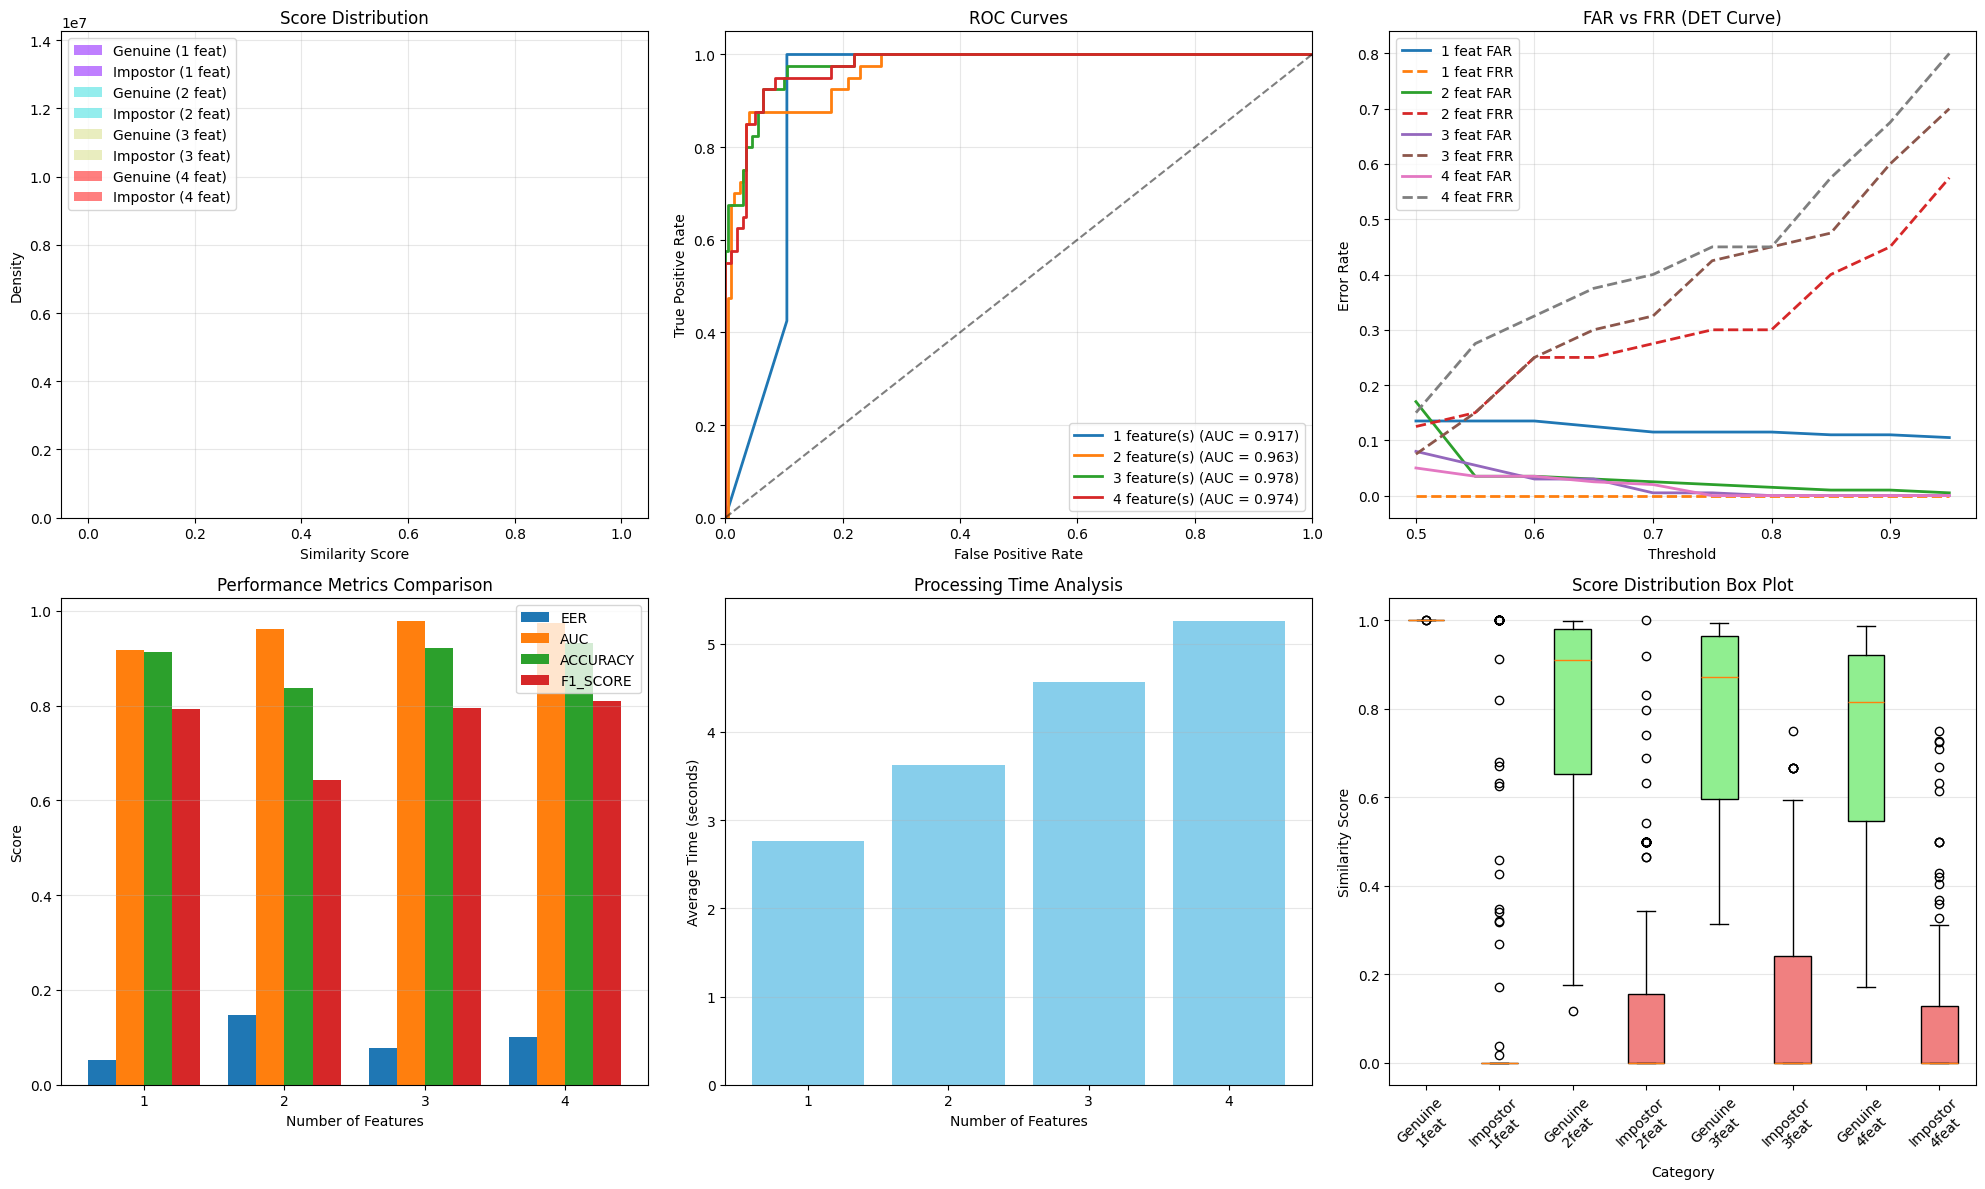


COMPREHENSIVE PERFORMANCE REPORT

✓ BEST CONFIGURATION: 1 feature(s)
  - EER: 0.0525
  - AUC: 0.9173
  - Accuracy: 0.9125
  - Recommended Threshold: 0.9500

EVALUATION COMPLETED


In [ ]:
# For quick testing:
results = quick_evaluation(num_users=30, threshold=0.75)

# For comprehensive analysis:
all_results = evaluate_authentication_performance(
    num_users=40,
    threshold_range=np.arange(0.5, 1.0, 0.05),
    num_features_list=[1, 2, 3, 4]  # Test with 1-4 features
)

In [ ]:
results = quick_evaluation(num_users=30, threshold=0.51)



QUICK PERFORMANCE EVALUATION

Results at threshold 0.51:
  Genuine Attempts: 28/30 correct
  Impostor Attempts: 30/30 correct
  False Acceptance Rate (FAR): 0.0000
  False Rejection Rate (FRR): 0.0667
  Overall Accuracy: 0.9667
  Genuine Score Mean: 0.8403
  Impostor Score Mean: 0.0553


In [ ]:
def evaluate_with_eer(num_users=50, threshold=0.95):
    """
    Evaluate authentication system performance with Equal Error Rate (EER) calculation

    Parameters:
    - num_users: Number of users to test (default: 50)
    - threshold: Decision threshold for authentication (default: 0.95)

    Returns:
    - Dictionary containing all evaluation results and metrics
    """
    print("\n" + "="*70)
    print("AUTHENTICATION EVALUATION WITH EQUAL ERROR RATE (EER)")
    print("="*70)

    results = {
        'genuine': {'scores': [], 'count': 0, 'correct': 0},
        'impostor': {'scores': [], 'count': 0, 'correct': 0}
    }

    for user_id in list(data.keys())[:num_users]:
        if user_id not in encrypted_database:
            continue

        # Test with 2 features
        query_features = [
            data[user_id]["features"][0],
            data[user_id]["features"][1]
        ]

        # Genuine attempt
        try:
            target_data = encrypted_database[user_id]
            target_public_context = ts.context_from(target_data['public_key'])

            # Encrypt queries
            enc_queries = [ts.ckks_vector(target_public_context, q) for q in query_features]

            # Get private context
            user_private_context = ts.context_from(user_private_keys[user_id])

            # Compare with first template
            enc_feat = ts.ckks_vector_from(target_public_context, target_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat)

                # Decrypt
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['genuine']['scores'].append(avg_score)
            results['genuine']['count'] += 1
            if avg_score >= threshold:
                results['genuine']['correct'] += 1

        except Exception as e:
            continue

        # Impostor attempt (against different user)
        try:
            imposter_id = [uid for uid in encrypted_database.keys() if uid != user_id][0]
            imposter_data = encrypted_database[imposter_id]
            imposter_public_context = ts.context_from(imposter_data['public_key'])

            # Re-encrypt with imposter's key
            enc_queries_imp = [ts.ckks_vector(imposter_public_context, q) for q in query_features]
            enc_feat_imp = ts.ckks_vector_from(imposter_public_context, imposter_data['encrypted_features'][0])

            feature_scores = []
            for enc_query in enc_queries_imp:
                dot_product, norm_sq_v1, norm_sq_v2 = cosine_similarity_encrypted_public(enc_query, enc_feat_imp)

                # Decrypt with original user's key
                dot_product_dec = ts.ckks_vector_from(user_private_context, dot_product.serialize()).decrypt()[0]
                norm_sq_v1_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v1.serialize()).decrypt()[0])
                norm_sq_v2_dec = max(0, ts.ckks_vector_from(user_private_context, norm_sq_v2.serialize()).decrypt()[0])

                norm_v1 = np.sqrt(norm_sq_v1_dec) if norm_sq_v1_dec > 0 else 0
                norm_v2 = np.sqrt(norm_sq_v2_dec) if norm_sq_v2_dec > 0 else 0

                if norm_v1 == 0 or norm_v2 == 0:
                    similarity = 0.0
                else:
                    similarity = dot_product_dec / (norm_v1 * norm_v2)

                similarity = max(-1.0, min(1.0, similarity))
                feature_scores.append(similarity)

            avg_score = sum(feature_scores) / len(feature_scores)
            results['impostor']['scores'].append(avg_score)
            results['impostor']['count'] += 1
            if avg_score < threshold:
                results['impostor']['correct'] += 1

        except Exception as e:
            continue

    # Calculate metrics including EER
    if results['genuine']['count'] > 0 and results['impostor']['count'] > 0:
        # Standard metrics at given threshold
        far = 1 - (results['impostor']['correct'] / results['impostor']['count'])
        frr = 1 - (results['genuine']['correct'] / results['genuine']['count'])
        accuracy = (results['genuine']['correct'] + results['impostor']['correct']) / \
                  (results['genuine']['count'] + results['impostor']['count'])

        # Calculate EER (Equal Error Rate)
        # Combine all scores for threshold range
        all_scores = results['genuine']['scores'] + results['impostor']['scores']
        thresholds = np.linspace(min(all_scores), max(all_scores), 200)

        far_list = []
        frr_list = []

        for t in thresholds:
            # FAR: impostor scores >= threshold
            far_t = sum(score >= t for score in results['impostor']['scores']) / len(results['impostor']['scores'])
            # FRR: genuine scores < threshold
            frr_t = sum(score < t for score in results['genuine']['scores']) / len(results['genuine']['scores'])

            far_list.append(far_t)
            frr_list.append(frr_t)

        far_array = np.array(far_list)
        frr_array = np.array(frr_list)

        # Find EER (where FAR and FRR are closest)
        diff = np.abs(far_array - frr_array)
        eer_idx = np.argmin(diff)
        eer = (far_array[eer_idx] + frr_array[eer_idx]) / 2
        eer_threshold = thresholds[eer_idx]

        # Calculate additional metrics
        # d-prime (sensitivity index)
        genuine_mean = np.mean(results['genuine']['scores'])
        impostor_mean = np.mean(results['impostor']['scores'])
        genuine_std = np.std(results['genuine']['scores'])
        impostor_std = np.std(results['impostor']['scores'])

        pooled_std = np.sqrt((genuine_std**2 + impostor_std**2) / 2)
        d_prime = (genuine_mean - impostor_mean) / pooled_std if pooled_std > 0 else 0

        # Calculate AUC
        from sklearn.metrics import roc_curve, auc
        y_true = [1] * len(results['genuine']['scores']) + [0] * len(results['impostor']['scores'])
        y_scores = results['genuine']['scores'] + results['impostor']['scores']
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Print comprehensive results
        print(f"\n{'='*50}")
        print(f"RESULTS at threshold {threshold}:")
        print(f"{'='*50}")
        print(f"  Genuine Attempts: {results['genuine']['correct']}/{results['genuine']['count']} correct")
        print(f"  Impostor Attempts: {results['impostor']['correct']}/{results['impostor']['count']} correct")
        print(f"  False Acceptance Rate (FAR): {far:.4f}")
        print(f"  False Rejection Rate (FRR): {frr:.4f}")
        print(f"  Overall Accuracy: {accuracy:.4f}")

        print(f"\n{'='*50}")
        print(f"EQUAL ERROR RATE (EER) ANALYSIS:")
        print(f"{'='*50}")
        print(f"  Equal Error Rate (EER): {eer:.4f}")
        print(f"  Threshold at EER: {eer_threshold:.4f}")
        print(f"  FAR at EER: {far_array[eer_idx]:.4f}")
        print(f"  FRR at EER: {frr_array[eer_idx]:.4f}")

        print(f"\n{'='*50}")
        print(f"ADDITIONAL METRICS:")
        print(f"{'='*50}")
        print(f"  AUC (Area Under ROC Curve): {roc_auc:.4f}")
        print(f"  d-prime (sensitivity index): {d_prime:.4f}")
        print(f"  Genuine Score Mean: {genuine_mean:.4f} ± {genuine_std:.4f}")
        print(f"  Impostor Score Mean: {impostor_mean:.4f} ± {impostor_std:.4f}")
        print(f"  Class Separation: {genuine_mean - impostor_mean:.4f}")

        # Add to results dictionary
        results['eer'] = eer
        results['eer_threshold'] = eer_threshold
        results['auc'] = roc_auc
        results['d_prime'] = d_prime
        results['far_at_given_threshold'] = far
        results['frr_at_given_threshold'] = frr
        results['accuracy_at_given_threshold'] = accuracy

        # Plot EER curve
        plot_eer_curve(results['genuine']['scores'], results['impostor']['scores'], eer, eer_threshold)

    return results

def plot_eer_curve(genuine_scores, impostor_scores, eer, eer_threshold):
    """
    Plot EER curve for evaluation
    """
    plt.figure(figsize=(10, 6))

    # Calculate FAR and FRR for all thresholds
    all_scores = genuine_scores + impostor_scores
    thresholds = np.linspace(min(all_scores), max(all_scores), 200)

    far = []
    frr = []

    for t in thresholds:
        far.append(sum(score >= t for score in impostor_scores) / len(impostor_scores))
        frr.append(sum(score < t for score in genuine_scores) / len(genuine_scores))

    far = np.array(far)
    frr = np.array(frr)

    # Plot
    plt.plot(thresholds, far, 'b-', label='FAR (False Acceptance Rate)', linewidth=2)
    plt.plot(thresholds, frr, 'r-', label='FRR (False Rejection Rate)', linewidth=2)

    # Mark EER point
    plt.plot(eer_threshold, eer, 'go', markersize=10, label=f'EER = {eer:.4f}')
    plt.axvline(x=eer_threshold, color='g', linestyle='--', alpha=0.5)
    plt.axhline(y=eer, color='g', linestyle='--', alpha=0.5)

    # Fill between curves
    plt.fill_between(thresholds, 0, np.minimum(far, frr), alpha=0.3, color='yellow',
                     label='Error Region')

    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Error Rate', fontsize=12)
    plt.title(f'Equal Error Rate (EER) Analysis\nEER = {eer:.4f} at Threshold = {eer_threshold:.4f}',
              fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim([min(all_scores), max(all_scores)])
    plt.ylim([0, 1])

    # Add statistics box
    textstr = f'Genuine: μ={np.mean(genuine_scores):.3f} σ={np.std(genuine_scores):.3f}\nImpostor: μ={np.mean(impostor_scores):.3f} σ={np.std(impostor_scores):.3f}\nSeparation: {np.mean(genuine_scores) - np.mean(impostor_scores):.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()


AUTHENTICATION EVALUATION WITH EQUAL ERROR RATE (EER)

RESULTS at threshold 0.51:
  Genuine Attempts: 37/43 correct
  Impostor Attempts: 43/43 correct
  False Acceptance Rate (FAR): 0.0000
  False Rejection Rate (FRR): 0.1395
  Overall Accuracy: 0.9302

EQUAL ERROR RATE (EER) ANALYSIS:
  Equal Error Rate (EER): 0.0698
  Threshold at EER: 0.2679
  FAR at EER: 0.0698
  FRR at EER: 0.0698

ADDITIONAL METRICS:
  AUC (Area Under ROC Curve): 0.9881
  d-prime (sensitivity index): 3.6196
  Genuine Score Mean: 0.7878 ± 0.2572
  Impostor Score Mean: 0.0105 ± 0.1614
  Class Separation: 0.7773


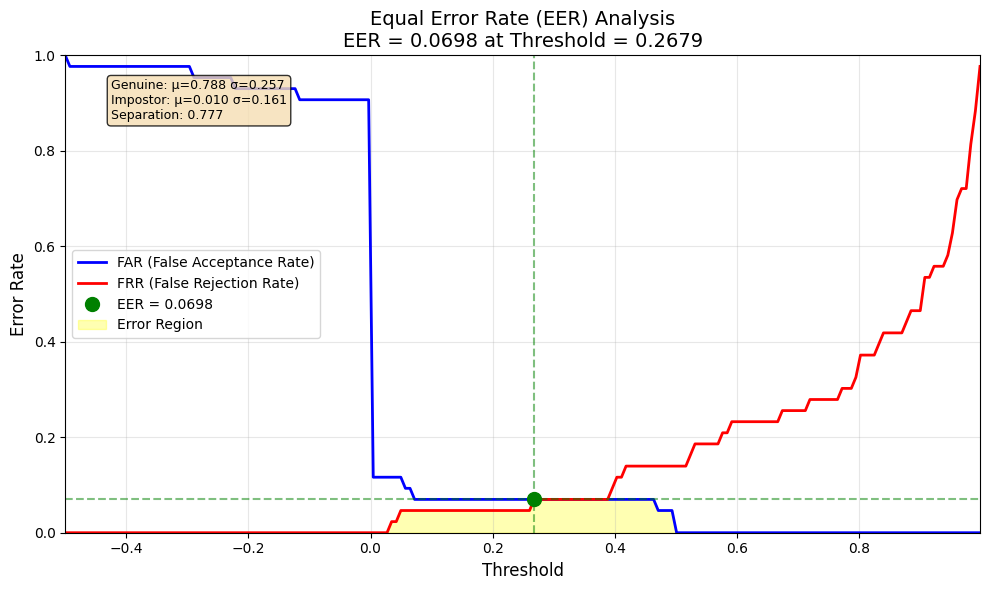

In [ ]:
results = evaluate_with_eer(num_users=43, threshold=0.51)